In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from textwrap import wrap


In [31]:
amazon_data = pd.read_csv('../data/cleaned/cleaned_data.csv')

In [32]:
amazon_data.head()

dateAdded                dateUpdated  \
0  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
1  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
2  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
3  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
4  2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   

                                                name   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   

  primaryCategories               reviews.date  reviews.rating  \
0       Electronics  2017-09-03 00:00:00+00:00               3   
1       Electronics  2017-06-06 00:00:00+00:00               5   
2       Electronics  2018-04-20 00:00:00+00:00               4   
3       Electronics  2017-11-02 17:33:31+00:00               5   
4       Electronics  2018-04-24 00:00:00+00:00               5   

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                  reviews.title reviews.username  
0                                     Too small           llyyue  
1  Great light reader. Easy to use at the beach           Charmi  
2                           Great for the price     johnnyjojojo  
3                                   A Great Buy          Kdperry  
4      Solid entry-level Kindle. Great for kids      Johnnyblack

Total ratings 4987
Total users 3807
User giving bulk rating (more than 10)8
Bulk ratings : 116
Populations of bulk ratings : 2.3260477240826147
Populations of bulk users : 0.21013921723141582


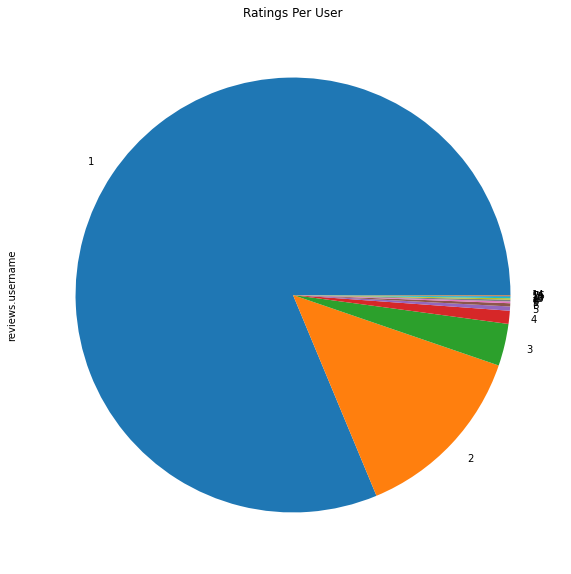

In [33]:
# Check it ratings are genuine 
rating_perperson = amazon_data['reviews.username'].value_counts()
print("Total ratings "+str(sum(rating_perperson)))
print("Total users "+str(len(rating_perperson)))
print("User giving bulk rating (more than 10)"+ str(sum(rating_perperson > 10)))
bulk = rating_perperson[rating_perperson >10]
bulk_rating = sum(bulk)
print ("Bulk ratings : " + str(bulk_rating))
print ("Populations of bulk ratings : " + str(bulk_rating*100/sum(rating_perperson)))
print ("Populations of bulk users : " + str(sum(rating_perperson >10)*100/len(rating_perperson)))
rating_perperson.value_counts().plot(kind='pie',figsize=(10,10), title='Ratings Per User')

Only 0.2 % users are bulk users 

count    116.000000
mean       4.586207
std        0.723145
min        2.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: reviews.rating, dtype: float64
count    4871.000000
mean        4.595976
std         0.732760
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews.rating, dtype: float64


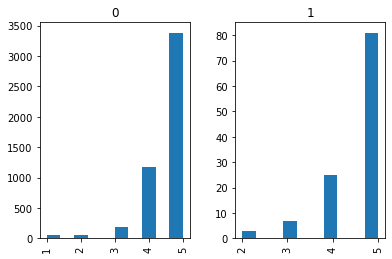

In [34]:
amazon_data['bulk']= amazon_data['reviews.username'].apply(lambda x : 1 if x in bulk.index else 0)
#gives us the category whether a rating is bulk or not 
print(amazon_data['reviews.rating'].hist(by=amazon_data.bulk))
print(amazon_data[amazon_data.bulk==1]['reviews.rating'].describe())
print(amazon_data[amazon_data.bulk==0]['reviews.rating'].describe())

The bulk rating distribution is same as normal rating so it is not a spam

*** Rating distribution ***
5    3465
4    1208
3     197
1      63
2      54
Name: reviews.rating, dtype: int64


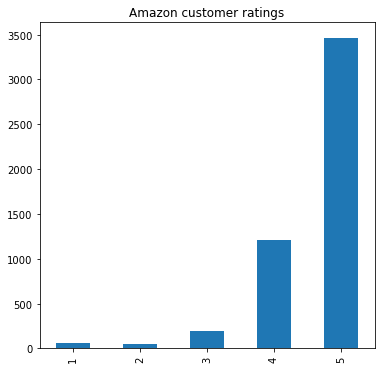

In [35]:
# Distribution on ratings 
star = amazon_data['reviews.rating'].value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

In [36]:
data = amazon_data.groupby('name').mean().reset_index()


In [37]:
data = data.sort_values(['reviews.rating']).reset_index()

In [38]:
data.head()

index                                               name  reviews.rating  \
0      1  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...        4.400000   
1     11  Amazon Kindle E-Reader 6" Wifi (8th Generation...        4.406250   
2     19  Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...        4.460916   
3     12  Amazon Tap - Alexa-Enabled Portable Bluetooth ...        4.506667   
4     15  Fire HD 8 Tablet with Alexa, 8" HD Display, 32...        4.509434   

       bulk  
0  0.000000  
1  0.041667  
2  0.026954  
3  0.013333  
4  0.000000

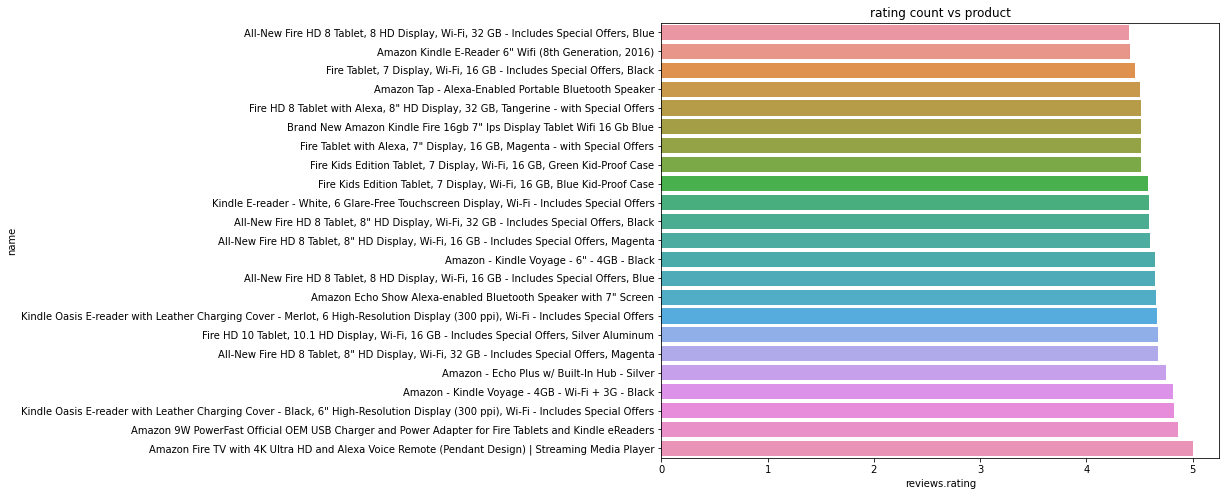

In [39]:
plt.figure(figsize=(10,8))
sns.barplot(x=data['reviews.rating'],y=data['name'])
plt.title('rating count vs product')
plt.show()

In [40]:
amazon_data['reviewsText']=amazon_data['reviews.text'] + amazon_data['reviews.title']
amazon_data.drop(['reviews.text','reviews.title'],axis=1)

dateAdded                dateUpdated  \
0     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
1     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
2     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
3     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
4     2017-03-03 16:56:05+00:00  2018-10-25 16:36:31+00:00   
...                         ...                        ...   
4982  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4983  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4984  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4985  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   
4986  2017-03-06 14:59:25+00:00  2017-09-04 11:19:31+00:00   

                                                   name   brand  \
0     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
1     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
2     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
4     Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
...                                                 ...     ...   
4982  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4983  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4984  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4985  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   
4986  Fire Tablet with Alexa, 7" Display, 16 GB, Mag...  Amazon   

     primaryCategories               reviews.date  reviews.rating  \
0          Electronics  2017-09-03 00:00:00+00:00               3   
1          Electronics  2017-06-06 00:00:00+00:00               5   
2          Electronics  2018-04-20 00:00:00+00:00               4   
3          Electronics  2017-11-02 17:33:31+00:00               5   
4          Electronics  2018-04-24 00:00:00+00:00               5   
...                ...                        ...             ...   
4982       Electronics  2016-10-21 00:00:00+00:00               5   
4983       Electronics  2016-08-10 00:00:00+00:00               5   
4984       Electronics  2016-06-05 00:00:00+00:00               4   
4985       Electronics  2016-09-02 00:00:00+00:00               5   
4986       Electronics  2016-05-19 00:00:00+00:00               5   

     reviews.username  bulk                                        reviewsText  
0              llyyue     0  I thought it would be as big as small paper bu...  
1              Charmi     0  This kindle is light and easy to use especiall...  
2        johnnyjojojo     0  Didnt know how much i'd use a kindle so went f...  
3             Kdperry     0  I am 100 happy with my purchase. I caught it o...  
4         Johnnyblack     0  Solid entry level Kindle. Great for kids. Gift...  
...               ...   ...                                                ...  
4982            litle     0  This is a great tablet for the price. Amazon i...  
4983           gracie     0  This tablet is the perfect size and so easy to...  
4984             Hawk     0  Purchased this for my son. Has room to upgrade...  
4985          Mrbilly     0  I had some thoughts about getting this for a 5...  
4986           tabman     0  this is a steal, have 8 gb model as well.This ...  

[4987 rows x 10 columns]

In [41]:
# !pip install WordCloud

In [42]:
# Removing unwanted characters from the names
amazon_data['name'].unique()
amazon_data['name'] = amazon_data['name'].apply(lambda x:x.split(',,,')[0])


In [43]:
amazon_data['reviewsText']

0       I thought it would be as big as small paper bu...
1       This kindle is light and easy to use especiall...
2       Didnt know how much i'd use a kindle so went f...
3       I am 100 happy with my purchase. I caught it o...
4       Solid entry level Kindle. Great for kids. Gift...
                              ...                        
4982    This is a great tablet for the price. Amazon i...
4983    This tablet is the perfect size and so easy to...
4984    Purchased this for my son. Has room to upgrade...
4985    I had some thoughts about getting this for a 5...
4986    this is a steal, have 8 gb model as well.This ...
Name: reviewsText, Length: 4987, dtype: object

## Preprocessing - removing punctuations, digits and unnecessary jargons

In [44]:
# Convert words to lower case in reviews text
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: x.lower())

In [45]:
# Eliminate digits and punctuations
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: re.sub('\w*\d\w*','',x))
amazon_data['reviewsText'] = amazon_data['reviewsText'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation),'',x))

In [46]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

words = amazon_data['reviewsText'].str.split()
stopwords_present = stopwords.words('english')
ps = PorterStemmer()
words = words.apply(lambda elem:[word for word in elem if not word in stopwords_present])
words = words.apply(lambda elem:[ps.stem(word) for word in elem])
amazon_data['cleanedReviewText'] = words.apply(lambda elem: ' '.join(elem))
amazon_data['cleanedReviewText'].head()

0    thought would big small paper turn like palm t...
1    kindl light easi use especi beachgreat light r...
2    didnt know much id use kindl went lower end im...
3    happi purchas caught sale realli good price no...
4    solid entri level kindl great kid gift kid fri...
Name: cleanedReviewText, dtype: object

In [92]:
sentiment= {1:0,
            2: 0,
            3: 1,
            4: 2,
            5: 2}

amazon_data["sentiment"] = amazon_data["reviews.rating"].map(sentiment)
amazon_data["sentiment"] = pd.to_numeric(amazon_data["sentiment"], errors='coerce')                                    
amazon_data = amazon_data.dropna(subset=["sentiment"])
amazon_data["sentiment"]  = amazon_data["sentiment"] .astype(int)
amazon_data['sentiment'].head()

0    1
1    2
2    2
3    2
4    2
Name: sentiment, dtype: int32

In [93]:
# Generate document term matrix  to find most occuring terms in reviews
text = amazon_data.copy()
cv = TfidfVectorizer(analyzer='word')
data = cv.fit_transform(text['cleanedReviewText'])
text_dm = pd.DataFrame(data.toarray(),columns=cv.get_feature_names())
text.set_index('name',inplace=True)
text_dm.index = text.index
text_dm.head()

abc  abil  abilitiesfun  \
name                                                                          
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...  0.0   0.0           0.0   

                                                    abilitiesnic  \
name                                                               
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0   

                                                    abilityexcel  abk  abl  \
name                                                                         
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...           0.0  0.0  0.0   

                                                    aboutfun  aboutgreat  \
name                                                                       
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0         0.0   

                                                    aboveoveral  ...  äúalexa  \
name                                                             ...            
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...          0.0  ...      0.0   

                                                    äúbest  äúdrop  \
name                                                                 
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...     0.0     0.0   

                                                    äúdualbatteri  äúshow  \
name                                                                        
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...            0.0     0.0   

                                                    äúskills  äústar  äúthing  \
name                                                                            
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0     0.0      0.0   
Amazon Kindle E-Reader 6" Wifi (8th Generation,...       0.0     0.0      0.0   
Amazon Kindle E-Re

In [94]:
text_dm.shape

(4987, 7144)

In [95]:
text_dm = text_dm.groupby(text_dm.index).sum()
text_dm.shape

(23, 7144)

In [96]:
text_dm.head()

abc      abil  \
name                                                                
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.0  0.000000   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.0  0.019080   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  1.679192   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.0  0.019080   

                                                    abilitiesfun  \
name                                                               
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0   

                                                    abilitiesnic  \
name                                                               
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...      0.000000   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...      0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.615179   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.000000   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...      0.000000   

                                                    abilityexcel  abk  \
name                                                                    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0  0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...           0.0  0.0   

                                                         abl  aboutfun  \
name                                                                     
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.133918       0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  0.191073       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  3.221180       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.000000       0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  0.248692       0.0   

                                                    aboutgreat  aboveoveral  \
name                                                                          
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...         0.0          0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...         0.0          0.0   

                                                    ...  äúalexa  äúbest  \
name                                                ...                    
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...  ...      0.0     0.0   

                                                    äúdrop  äúdualbatteri  \
name                                                                        
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...     0.0            0.0   
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, ...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi,...     0.0            0.0   
All-New Fire HD 8 Tablet, 8" HD Di

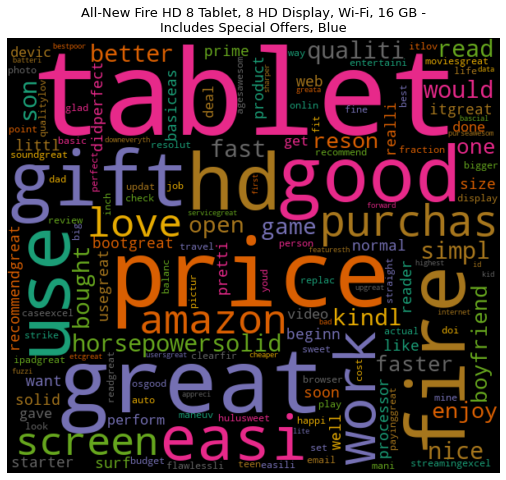

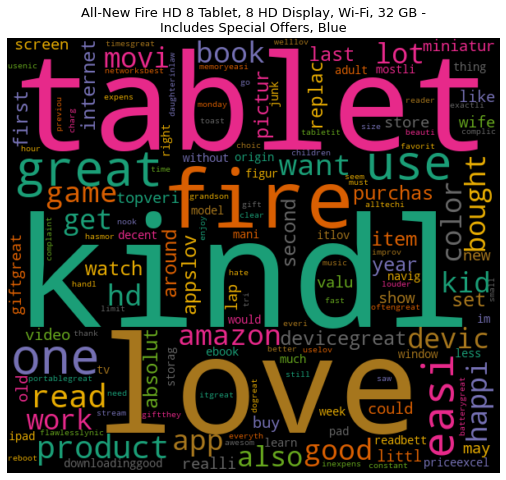

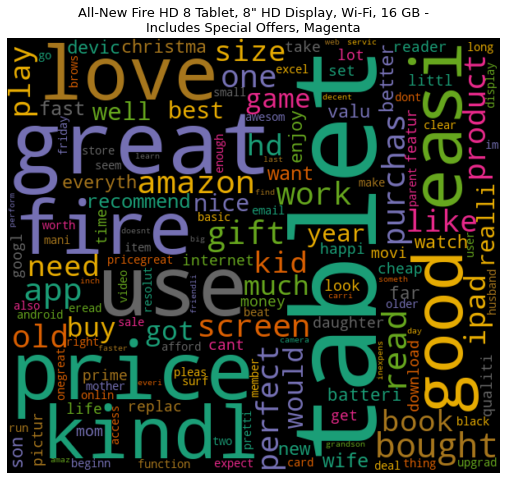

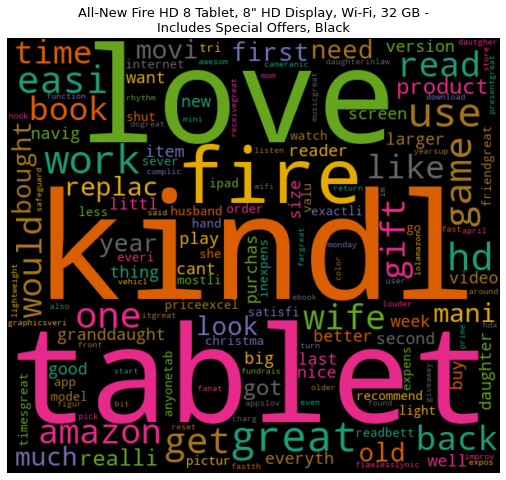

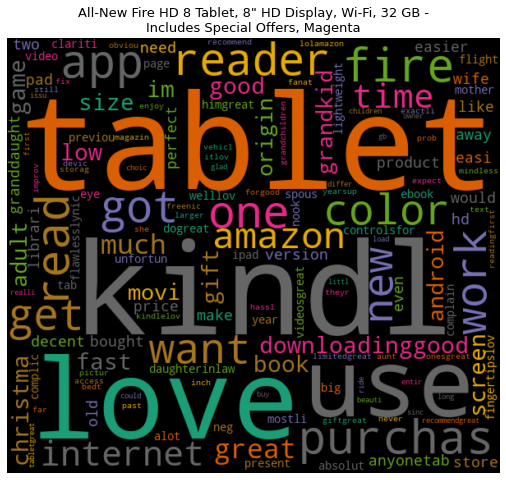

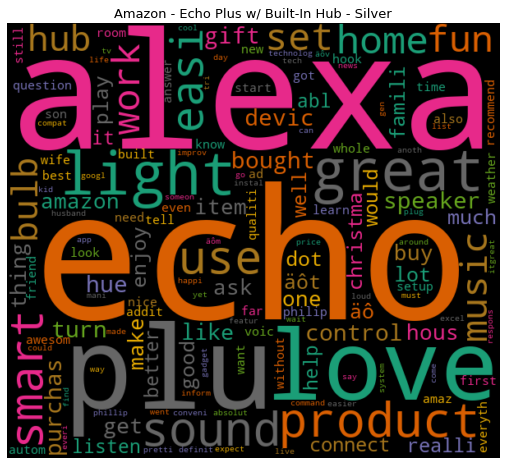

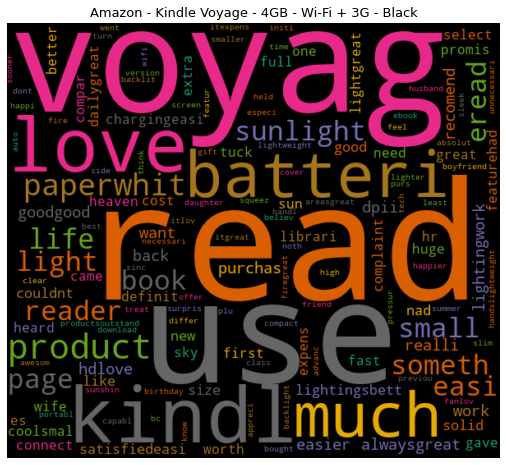

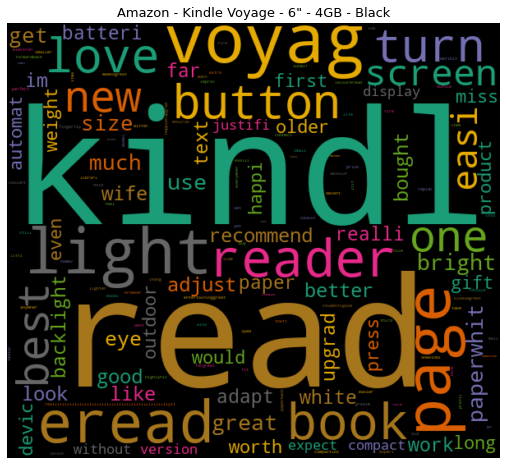

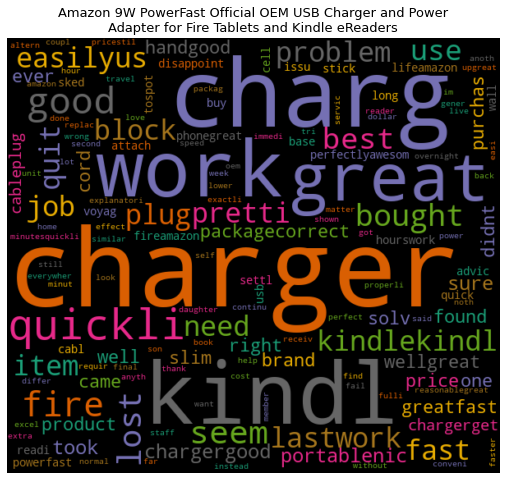

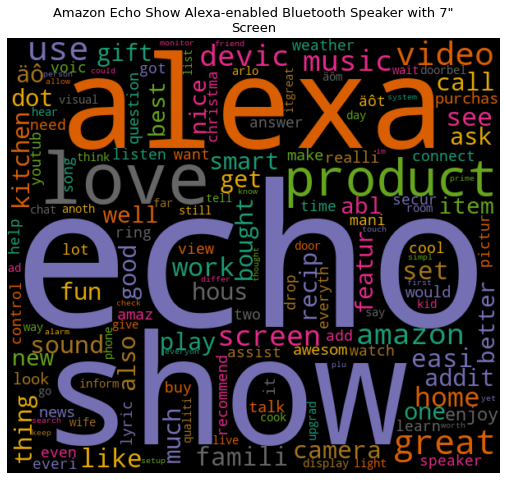

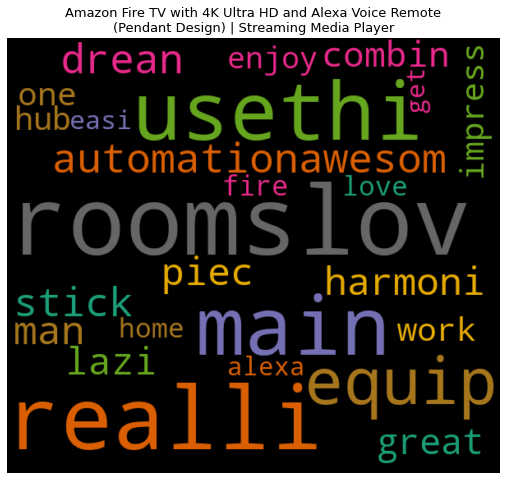

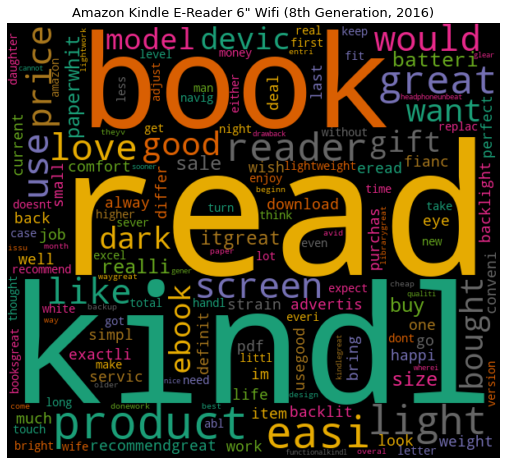

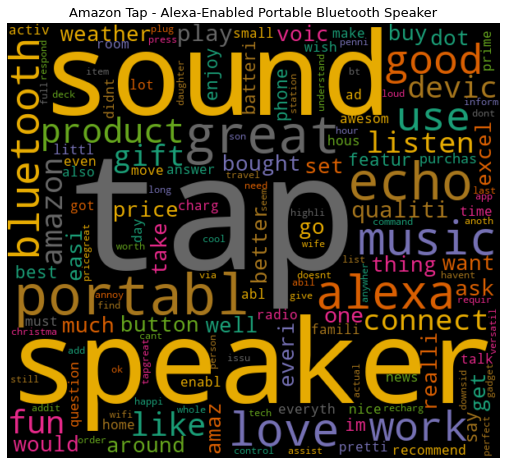

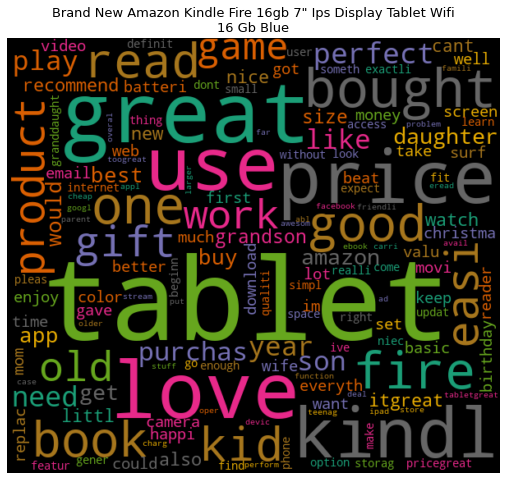

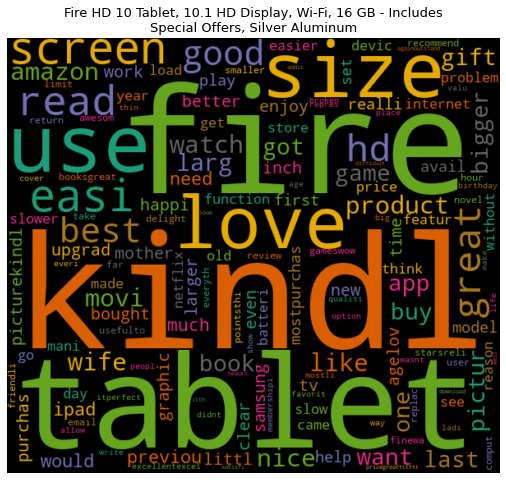

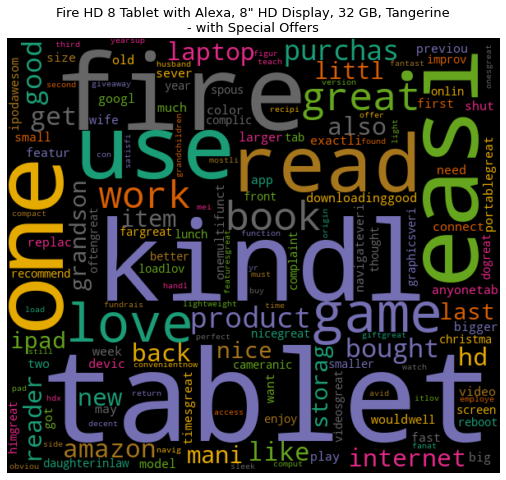

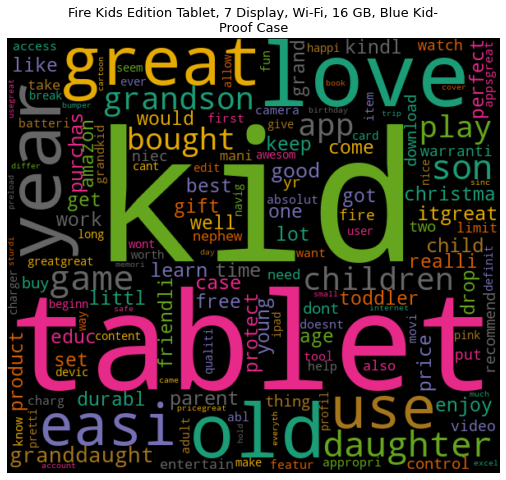

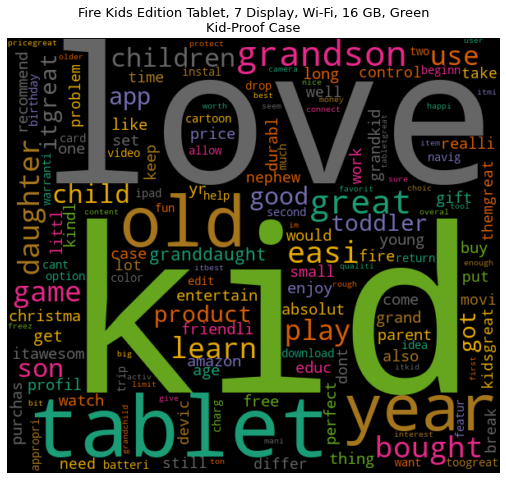

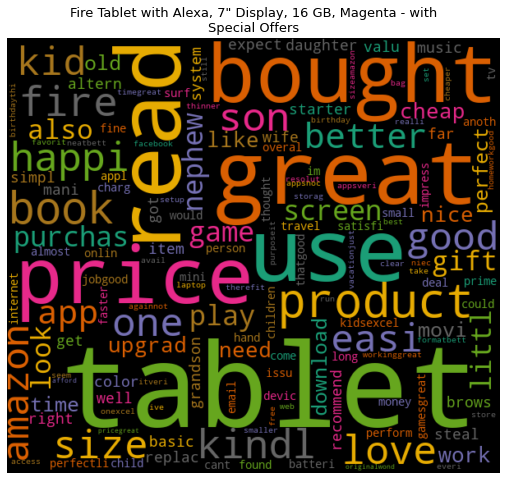

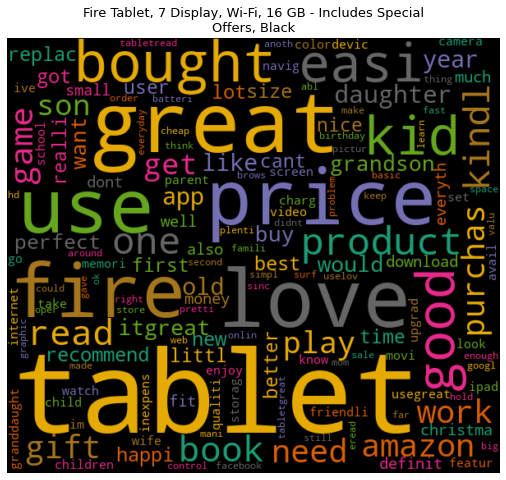

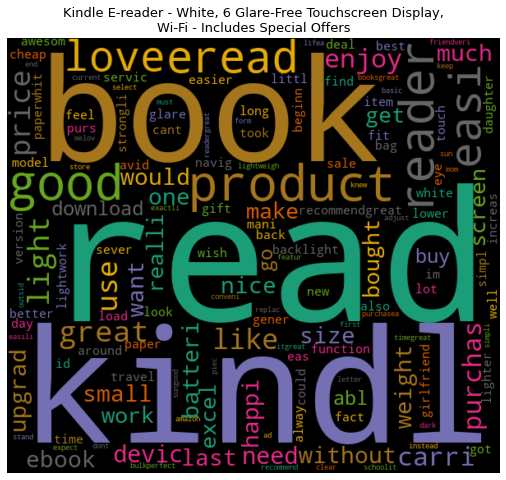

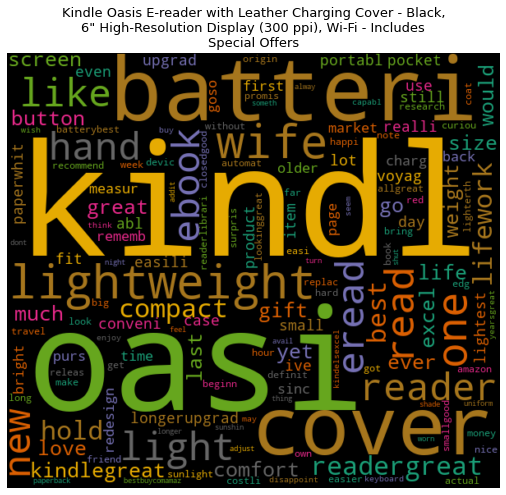

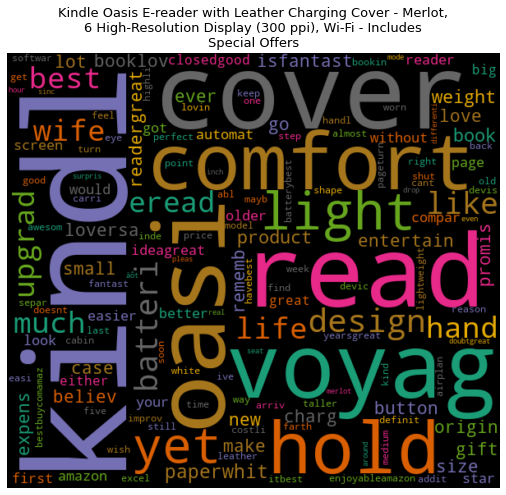

In [97]:
def wordcloud(data,title):
  wc = WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
text_dm = text_dm.transpose()
for index,product in enumerate(text_dm.columns):
   wordcloud(text_dm[product].sort_values(ascending=False),product)
    

### Splitting data into testing and training 

In [104]:
from sklearn.model_selection import train_test_split
y = text['sentiment'].values
X = pd.DataFrame(pd.DataFrame(data.toarray()))
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Modeling

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
lr = LogisticRegression(solver = 'liblinear', random_state = 0, max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='liblinear')

In [110]:
y_pred = lr.predict(X_test)
print('Train accuracy:',lr.score(X_train,y_train) * 100)
print('Test accuracy:',lr.score(X_test,y_test) * 100)
print('Confusion matrix:',confusion_matrix(y_test,y_pred))
print('Classification report:',classification_report(y_test,y_pred))

Train accuracy: 93.60742040611683
Test accuracy: 94.38877755511022
Confusion matrix: [[  0   0  20]
 [  0   0  36]
 [  0   0 942]]
Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        36
           2       0.94      1.00      0.97       942

    accuracy                           0.94       998
   macro avg       0.31      0.33      0.32       998
weighted avg       0.89      0.94      0.92       998



C:\Users\hp pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
